### Seminar 6: Atomic structure encoding

Goals/Agenda
- Features importance study

- Forward feature selection
- Matminer for crystal structure featurization
- Datasets size vs. model performance
- Including geometrical features
- Writing featurizers



### Part 1: Feature importance

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# download files
!mkdir data
!wget -O./data/eg_double_perovskites.csv https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar05/eg_double_perovskites.csv

In [2]:
data = pd.read_csv('data/eg_double_perovskites.csv')
data = data[data.Insulator == 1]

In [3]:
data = data[data.Insulator == 1]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1577 entries, 12 to 5145
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   functional group  1577 non-null   object 
 1   A                 1577 non-null   object 
 2   A_OS              1577 non-null   int64  
 3   A'                1577 non-null   object 
 4   A'_OS             1577 non-null   int64  
 5   A_HOMO-           1577 non-null   float64
 6   A_HOMO+           1577 non-null   float64
 7   A_IE-             1577 non-null   float64
 8   A_IE+             1577 non-null   float64
 9   A_LUMO-           1577 non-null   float64
 10  A_LUMO+           1577 non-null   float64
 11  A_X-              1577 non-null   float64
 12  A_X+              1577 non-null   float64
 13  A_Z_radii-        1577 non-null   float64
 14  A_Z_radii+        1577 non-null   float64
 15  A_e_affin-        1577 non-null   float64
 16  A_e_affin+        1577 non-null   float64
 17 

In [5]:
data = data.drop(['functional group', 'A', "A'", "B'", "Bi", 'Insulator'], axis = 1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1577 entries, 12 to 5145
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   A_OS          1577 non-null   int64  
 1   A'_OS         1577 non-null   int64  
 2   A_HOMO-       1577 non-null   float64
 3   A_HOMO+       1577 non-null   float64
 4   A_IE-         1577 non-null   float64
 5   A_IE+         1577 non-null   float64
 6   A_LUMO-       1577 non-null   float64
 7   A_LUMO+       1577 non-null   float64
 8   A_X-          1577 non-null   float64
 9   A_X+          1577 non-null   float64
 10  A_Z_radii-    1577 non-null   float64
 11  A_Z_radii+    1577 non-null   float64
 12  A_e_affin-    1577 non-null   float64
 13  A_e_affin+    1577 non-null   float64
 14  B_OS          1577 non-null   int64  
 15  B'_OS         1577 non-null   float64
 16  B_HOMO-       1577 non-null   float64
 17  B_HOMO+       1577 non-null   float64
 18  B_IE-         1577 non-null   fl

Let's analyze the correlation between the features and the target property (PBE band gap)

In [7]:
corr_data = data.corr()['PBE band gap'].sort_values()[:-1] # -1 is to drop target value

<BarContainer object of 33 artists>

/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


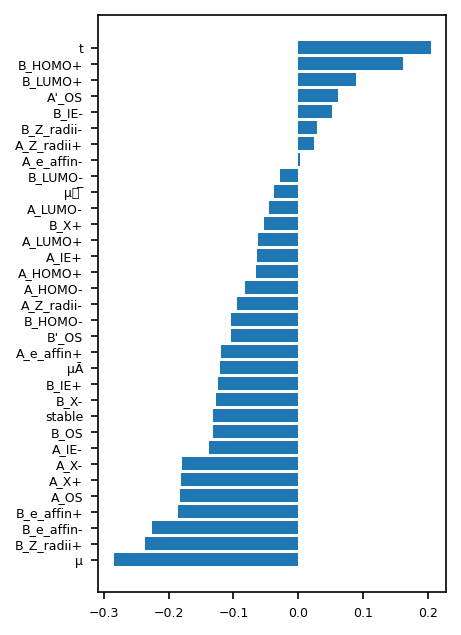

In [8]:
plt.rcParams.update({'font.size': 6})
plt.figure(dpi = 150, figsize = (3,5))
plt.barh(corr_data.index, corr_data.values)

I would expect the features with the highest correlation would be the most important. Will see.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [10]:
# split data into train and test subsamples
X = data.drop(['PBE band gap'], axis = 1)
y = data['PBE band gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

#### Model selection with grid search

Grid search is the method of optimizng hyperparameters of the model. We iteratively fit model for each set of possible hyperparameters.

In [11]:
from sklearn.model_selection import GridSearchCV


rf = RandomForestRegressor(n_estimators=50, random_state=1)
param_grid = [
  {
    'n_estimators': [20, 50, 100],
    'max_depth': [4, 6, 10, 12, 14, 16],
    'max_features': [2, 4, 8],
   },
]
gs = GridSearchCV(rf, param_grid, n_jobs=4, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7741060958624356
{'max_depth': 16, 'max_features': 8, 'n_estimators': 100}


In [12]:
model = RandomForestRegressor(**gs.best_params_, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,16
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,8
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
fi = model.feature_importances_
fea_labels = model.feature_names_in_

importances = pd.DataFrame()

importances['fi'] = fi
importances['fea_label'] = fea_labels


In [14]:
corr_data = pd.DataFrame(corr_data)
corr_data['fea_label'] = corr_data.index

In [15]:
df = corr_data.merge(importances)

<BarContainer object of 33 artists>

/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


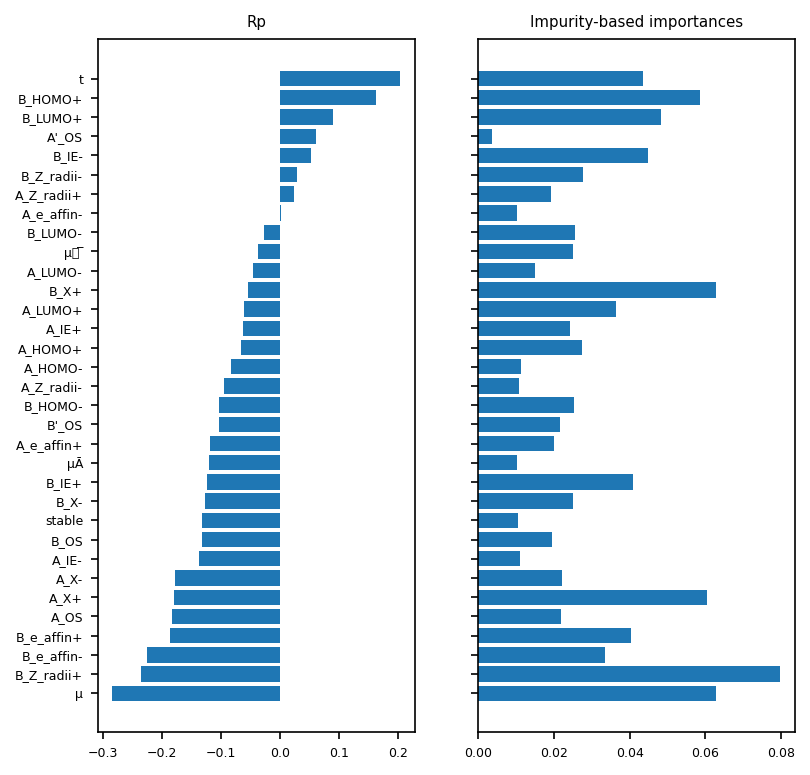

In [16]:
plt.rcParams.update({'font.size': 6})
fig, (ax1, ax2) = plt.subplots(dpi = 150, figsize = (6, 6), ncols = 2, sharey= True)
ax1.barh(df.fea_label, df['PBE band gap'])
ax1.set_title('Rp')

ax2.set_title('Impurity-based importances')
ax2.barh(df.fea_label, df.fi)

In [17]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train, y_train,
                           n_repeats=5,
                           random_state=0)

In [18]:
r.importances_mean
X_train.columns

pi = pd.DataFrame()

pi['fea_label'] = X_train.columns
pi['fi_pi'] = r.importances_mean

df_ = df.merge(pi)

In [19]:
df_

,PBE band gap,fea_label,fi,fi_pi
0,-0.284750,μ,0.062744,0.079455
1,-0.236494,B_Z_radii+,0.079743,0.122169
2,-0.224959,B_e_affin-,0.033523,0.028280
3,-0.185901,B_e_affin+,0.040406,0.035228
4,-0.182799,A_OS,0.021779,0.042791
5,-0.180455,A_X+,0.060493,0.120162
6,-0.178673,A_X-,0.022020,0.030730
7,-0.137359,A_IE-,0.010924,0.008850
8,-0.132137,B_OS,0.019397,0.017817
9,-0.132003,stable,0.010641,0.016661


Text(0.5, 1.0, 'Permutation importances')

/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


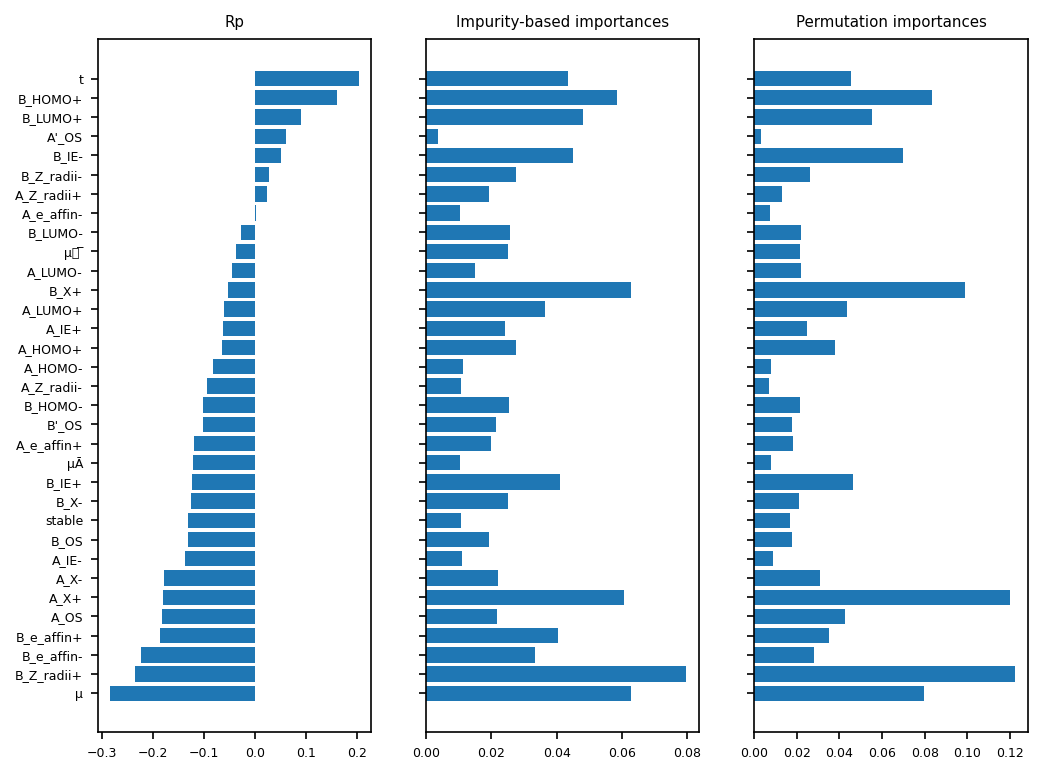

In [20]:
plt.rcParams.update({'font.size': 6})
fig, (ax1, ax2, ax3) = plt.subplots(dpi = 150, figsize = (8, 6), ncols = 3, sharey= True)

ax1.barh(df_.fea_label, df_['PBE band gap'])
ax1.set_title('Rp')

ax2.barh(df_.fea_label, df_.fi)
ax2.set_title('Impurity-based importances')


ax3.barh(df_.fea_label, df_.fi_pi)
ax3.set_title('Permutation importances')


As shown, some features exhibit low Pearson correlation coefficient ($R_p$) but high importance (for example, `B_X+`). This demonstrates why the correlation coefficient is not always a reliable measure of feature importance. The Pearson correlation coefficient ($R_p$):

- Captures only linear relationships
- Is sensitive to outliers  

- Performs poorly with categorical or highly discrete features

- Ignores features interaction

For more robust feature importance assessment, model-based methods are recommended. 

### Correaltion between features
 It is also useful to evaluate the correlation between features.

In [51]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,A_OS,A'_OS,A_HOMO-,A_HOMO+,A_IE-,A_IE+,A_LUMO-,A_LUMO+,A_X-,A_X+,A_Z_radii-,A_Z_radii+,A_e_affin-,A_e_affin+,B_OS,B'_OS,B_HOMO-,B_HOMO+,B_IE-,B_IE+,B_LUMO-,B_LUMO+,B_X-,B_X+,B_Z_radii-,B_Z_radii+,B_e_affin-,B_e_affin+,PBE band gap,μ,μĀ,μ𝐵 ̅,stable,t
A_OS,1.000000,0.204077,0.207463,0.453719,0.231275,0.028309,0.210017,-0.344810,0.255148,0.210928,0.203163,0.325719,0.203188,0.318895,-0.225352,-0.191488,-0.191488,0.313209,-0.191746,-0.246716,-0.170125,0.363464,-0.164732,-0.048924,-0.055894,-0.103927,-0.057229,-0.095799,-0.182799,0.036874,0.293310,-0.197261,-0.221206,-0.270316
A'_OS,0.204077,1.000000,-0.487509,0.095286,-0.641808,0.416375,-0.567620,-0.696344,-0.482861,0.195434,-0.470839,0.119073,-0.362609,-0.153092,-0.701710,-0.513738,-0.513738,0.510647,-0.439756,-0.525457,-0.525088,0.430866,-0.392495,-0.297374,-0.139042,-0.094104,-0.316903,-0.352905,0.060401,0.044583,-0.681962,-0.308955,-0.692621,-0.511315
A_HOMO-,0.207463,-0.487509,1.000000,0.072537,0.759655,-0.168847,0.532143,0.370410,0.623821,0.054866,0.720598,-0.011460,0.665449,0.283251,0.460338,0.181979,0.181979,-0.222461,0.162805,0.221845,0.264225,-0.054203,0.195279,0.353711,-0.067641,-0.151273,0.159663,0.153327,-0.082570,-0.174068,0.620698,0.027348,0.356110,0.314157
A_HOMO+,0.453719,0.095286,0.072537,1.000000,0.168971,-0.357475,0.257347,-0.171009,0.030003,-0.088780,0.098102,0.496087,0.109211,0.428147,0.006466,-0.256513,-0.256513,0.373895,-0.268975,-0.315844,-0.205013,0.189464,-0.229033,-0.128650,-0.117378,-0.040660,-0.238562,-0.162348,-0.065766,-0.002188,0.272365,-0.235237,-0.194536,-0.106438
A_IE-,0.231275,-0.641808,0.759655,0.168971,1.000000,-0.262697,0.550262,0.475559,0.827761,0.044588,0.773610,0.030342,0.585110,0.366159,0.514148,0.244296,0.244296,-0.255580,0.199800,0.270900,0.352842,-0.156681,0.211261,0.282467,-0.021277,-0.058974,0.185944,0.212968,-0.137359,-0.086007,0.829384,0.079129,0.456994,0.339694
A_IE+,0.028309,0.416375,-0.168847,-0.357475,-0.262697,1.000000,-0.420386,0.108625,-0.030928,0.766977,-0.151945,-0.618409,-0.047100,-0.005398,-0.356742,-0.260038,-0.260038,0.060555,-0.239687,-0.107641,-0.128002,0.147085,-0.188918,0.011594,-0.127184,-0.151457,-0.066549,-0.143088,-0.063622,-0.098149,-0.409246,-0.188808,-0.297705,-0.296936
A_LUMO-,0.210017,-0.567620,0.532143,0.257347,0.550262,-0.420386,1.000000,0.195720,0.404143,-0.150844,0.513916,0.203468,0.422366,0.245201,0.485581,0.258850,0.258850,-0.221334,0.208768,0.243806,0.196294,-0.051742,0.193442,0.202809,0.006490,-0.065040,0.179529,0.190583,-0.045328,-0.088941,0.649153,0.125600,0.420031,0.310939
A_LUMO+,-0.344810,-0.696344,0.370410,-0.171009,0.475559,0.108625,0.195720,1.000000,0.458105,0.232381,0.344941,-0.456823,0.315913,0.166942,0.478587,0.304165,0.304165,-0.482097,0.244529,0.450603,0.457227,-0.414000,0.244625,0.290217,0.014930,-0.003598,0.227926,0.222121,-0.061848,-0.117804,0.395111,0.141776,0.548333,0.362393
A_X-,0.255148,-0.482861,0.623821,0.030003,0.827761,-0.030928,0.404143,0.458105,1.000000,0.262721,0.750534,-0.145884,0.482345,0.316310,0.379548,0.210707,0.210707,-0.297268,0.167916,0.299434,0.317839,-0.127045,0.201565,0.277136,-0.008908,-0.069888,0.255607,0.219869,-0.178673,-0.065254,0.606776,0.072983,0.389242,0.236914
A_X+,0.210928,0.195434,0.054866,-0.088780,0.044588,0.766977,-0.150844,0.232381,0.262721,1.000000,0.102875,-0.462973,0.082141,0.287532,-0.180047,-0.197501,-0.197501,0.013394,-0.208892,-0.046631,-0.032340,0.081462,-0.138539,0.058919,-0.128624,-0.142359,-0.015208,-0.091075,-0.180455,-0.093609,-0.095588,-0.189104,-0.129441,-0.116848


When features exhibit strong correlation, removing one from each correlated pair offers several benefits: 

- it yields simpler and more robust models
- reduces data collection requirements

- and streamlines the analysis of feature importance. 



In [93]:
from scipy.stats import spearmanr



def get_correlated_features(X, threshold = 0.85):
    feature_names = X.columns

    # we use Spearman coefficient instead of Rp
    corr = spearmanr(X_train).correlation 

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    correlated_features = []
    for i in range(len(corr)):
        for j in range(i):
            if abs(corr[i, j]) > threshold:
                feature_name = feature_names[i]
                if feature_name not in correlated_features:
                    correlated_features.append(feature_name)
    return correlated_features


# print(get_correlated_features(X_train, threshold=0.85))

### Task 1: Forward feature selection

- Implement a forward feature selection algorithm

- Select top10 features using RF model

- Plot  MSE(Eg prediction) vs # of seleted features

In [63]:
def MSE(pred, true):
    return np.square(pred - true).mean()

Note: It should be in a cross-validation loop. But for simplicity, we use a single data split of a train subsample into train and val parts.


In [54]:
features = X_train.columns

best_features = []
mse_history = []

X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle=True, random_state=42)


for k in tqdm(range(15)):
    best_score = np.inf
    current_best_feature = None
    for feature in features:
        pass

100%|██████████| 15/15 [00:00<00:00, 69136.88it/s]


Do these features correspond to the most important descriptors?

In [ ]:
best_features[:8]

In [ ]:
plt.figure(dpi = 150)
plt.plot(mse_history)
plt.ylabel('MSE')
plt.xlabel('# features')

### Part 2: Matminer

The [matminer package](https://hackingmaterials.lbl.gov/matminer/index.html) is developed for converting atomic structure into features.

Attribution: Parts of this notebook are adapted from the "Review of matminer features" by Enze Chen and Mark Asta (University of California, Berkeley)

source: https://colab.research.google.com/github/enze-chen/mi-book/blob/master/week_2/08/matminer_features_blank.ipynb#scrollTo=c7242cf7


#### Compositional features



We will use elemental features (Magpie) (see the [original paper](https://www.nature.com/articles/npjcompumats201628))

We take the property (such as `AtomicWeight` or `Electronegativity`) of all of the constituent elements and calculate its descriptive statistics - average, maximum, minimum, etc. 



In [ ]:
!pip install pymatgen
!pip install matminer

In [55]:
from pymatgen.core import Composition
from matminer.featurizers.composition import ElementProperty

features = [
'Number',
'MendeleevNumber',
'AtomicWeight',
'Column', 
'Row', 
'CovalentRadius', 
'Electronegativity', 
'NsValence', 
'NpValence', 
'NdValence',
'NfValence', 
'NValence', 
'NsUnfilled', 
'NpUnfilled',
'NdUnfilled', 
'NfUnfilled', 
'NUnfilled', 
'GSvolume_pa',
'GSbandgap',
'GSmagmom',
]

# these are the statistical quantities we can compute
stats = ['mean']   # we can also add 'minimum', 'maximum', 'range', 'avg_dev', 'mode'

featurizer = ElementProperty(data_source='magpie',
                             features=features,
                             stats=stats)



/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [56]:
data = pd.read_csv('data/eg_double_perovskites.csv')
data = data[data.Insulator == 1]

def _get_composition(formula):
    return Composition(formula)
    
data['composition'] = data['functional group'].apply(_get_composition)

In [57]:
df_features = featurizer.featurize_dataframe(data, col_id='composition')
feature_labels = featurizer.feature_labels()

ElementProperty: 100%|██████████| 1577/1577 [01:06<00:00, 23.76it/s]


In [58]:
data_new = df_features.drop(['functional group', 'A', "A'", "B'", "Bi", 'Insulator', 'composition'], axis = 1)

In [59]:
# split data into train and test subsamples
X = data_new.drop(['PBE band gap'], axis = 1)
y = data_new['PBE band gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)

In [61]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
from sklearn.metrics import r2_score
preds = model.predict(X_test)
print(f"RMSE: {round((np.sqrt(MSE(preds, y_test))), 3)}")
print(f"R_squared: {round(r2_score(y_test, preds), 3)}")

RMSE: 0.358
R_squared: 0.794


Text(0, 0.5, 'Pred')

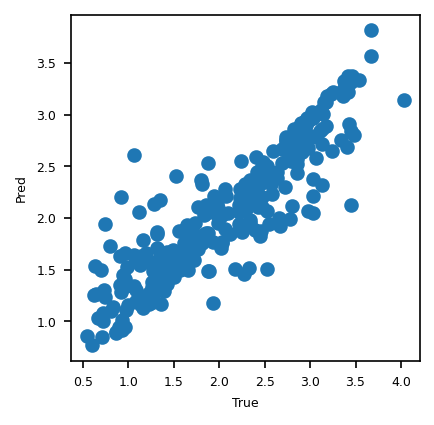

In [69]:
plt.figure(dpi = 150, figsize= (3, 3))
plt.scatter(y_test, preds)
plt.xlabel('True')
plt.ylabel('Pred')

In [83]:
data = pd.read_csv('data/eg_double_perovskites.csv')
data = data[data.Insulator == 1]
data = data.drop(['functional group', 'A', "A'", "B'", "Bi", 'Insulator'], axis = 1)
X = data.drop(['PBE band gap'], axis = 1)
y = data['PBE band gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)

In [86]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [88]:
preds = model.predict(X_test)
print(f"RMSE: {round((np.sqrt(MSE(preds, y_test))), 3)}")
print(f"R_squared: {round(r2_score(y_test, preds), 3)}")

RMSE: 0.356
R_squared: 0.796


The inclusion of gross level elemental features does not increase the score. Let's see if one of the included features is more important than the original one.

In [106]:
X = data_new.drop(['PBE band gap'], axis = 1)
y = data_new['PBE band gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)

correlated_features = get_correlated_features(X_train, threshold=0.85)
# remove correlated features
X_train = X_train.drop(columns = correlated_features)

features = X_train.columns

best_features = []
mse_history = []

X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle=True, random_state=42)


for k in tqdm(range(35)):
    best_score = np.inf
    current_best_feature = None
    for feature in features:
        if feature in best_features:
            continue
        current_features = best_features.copy()
        current_features.append(feature)

        X_step = X_train_[current_features].values
        if len(current_features) == 1:
            X_step = X_step.reshape(-1, 1)
        model = RandomForestRegressor(n_estimators=10) 
        model.fit(X_step, y_train_)
        pred = model.predict(X_val[current_features].values)
        score = MSE(pred, y_val) 
        if score < best_score:
            best_score = score
            current_best_feature = feature
    best_features.append(current_best_feature)
    mse_history.append(best_score)

100%|██████████| 35/35 [00:45<00:00,  1.30s/it]


In [107]:
best_features

['B_IE+',
 'MagpieData mean NUnfilled',
 'MagpieData mean NdValence',
 'A_X+',
 'μ',
 'MagpieData mean NpValence',
 'B_LUMO+',
 'B_LUMO-',
 'MagpieData mean NfUnfilled',
 'MagpieData mean CovalentRadius',
 'B_Z_radii-',
 'stable',
 'MagpieData mean GSbandgap',
 'A_HOMO+',
 'A_Z_radii+',
 'μ𝐵\xa0̅',
 'B_Z_radii+',
 'MagpieData mean NsValence',
 'A_HOMO-',
 'MagpieData mean NdUnfilled',
 'B_e_affin-',
 'MagpieData mean NValence',
 'MagpieData mean MendeleevNumber',
 'B_OS',
 't',
 'MagpieData mean GSvolume_pa',
 'MagpieData mean Electronegativity',
 'B_X+',
 "B'_OS",
 'B_e_affin+',
 'A_LUMO+',
 "A'_OS",
 'MagpieData mean NfValence',
 'A_IE+',
 'MagpieData mean GSmagmom']

Text(0.5, 0, '# features')

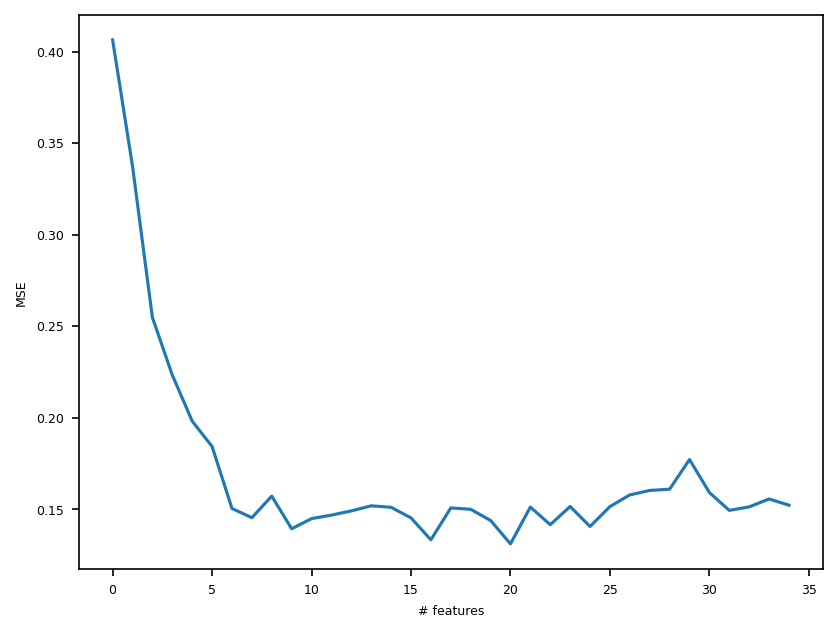

In [108]:
plt.figure(dpi = 150)
plt.plot(mse_history)
plt.ylabel('MSE')
plt.xlabel('# features')

In [109]:
mse_history[:20]

[0.40641340224597733,
 0.337471515884567,
 0.25477064366332475,
 0.2233154802700164,
 0.1981282708526349,
 0.184284706441485,
 0.15040871431676794,
 0.14536270971147594,
 0.15714648556792918,
 0.13928880529367568,
 0.14485238641936743,
 0.14677920949090903,
 0.14907484684071123,
 0.15184790173201557,
 0.15104101090197608,
 0.14524441933162036,
 0.1332781494948616,
 0.15070994646956512,
 0.14995239302292473,
 0.14386217153992079]

In [111]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train[best_features[:20]], y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Important: Feature selection was performed using n_estimators=10, but the final model employs n_estimators=100. This methodology is flawed. Feature selection must be conducted with the same hyperparameter values that will be used in the final model. We did this just for a quick example.

In [116]:
preds = model.predict(X_test[best_features[:20]])

In [117]:
print(f"RMSE: {round((np.sqrt(MSE(preds, y_test))), 3)}")
print(f"R_squared: {round(r2_score(y_test, preds), 3)}")

RMSE: 0.32
R_squared: 0.835


#### Some structural features

In [118]:
!wget -O./data/LiBr.cif https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar02/LiBr.cif

--2025-09-24 18:41:49--  https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar02/LiBr.cif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5419 (5,3K) [text/plain]
Saving to: ‘./data/LiBr.cif’

./data/LiBr.cif     100%[===================>]   5,29K  --.-KB/s    in 0s      

2025-09-24 18:41:49 (28,7 MB/s) - ‘./data/LiBr.cif’ saved [5419/5419]



In [119]:
from matminer.featurizers.structure import DensityFeatures
from pymatgen.core import Structure
st = Structure.from_file('data/LiBr.cif')

featurizer = DensityFeatures()

dict(zip(featurizer.feature_labels(), featurizer.featurize(st)))

{'density': 3.5724738210211786,
 'vpa': 20.183425052734915,
 'packing fraction': 0.47416820462238135}

#### Presets in matminer
Adapted from matminer [examples](https://github.com/hackingmaterials/matminer_examples/blob/main/matminer_examples/machine_learning-nb/voronoi-ward-prb-2017.ipynb)


Here we will try to predict formation energy of crystal structures using both elemental and geometrical descriptors. The geometrical properties are collected using Voronoi partitioning as implemnted in [Ward et al](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.024104).

In [120]:
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital, IonProperty
from matminer.featurizers.structure import (
                                            SiteStatsFingerprint,
                                            StructuralHeterogeneity,
                                            ChemicalOrdering,
                                            StructureComposition,
                                            MaximumPackingEfficiency
                                            )
from matminer.featurizers.conversions import DictToObject
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tqdm import tqdm_notebook as tqdm

In [121]:
# create featurizer
featurizer = MultipleFeaturizer([
    SiteStatsFingerprint.from_preset("CoordinationNumber_ward-prb-2017"),
    StructuralHeterogeneity(),
    ChemicalOrdering(),
    MaximumPackingEfficiency(),
    SiteStatsFingerprint.from_preset("LocalPropertyDifference_ward-prb-2017"),
    StructureComposition(Stoichiometry()),
    StructureComposition(ElementProperty.from_preset("magpie")),
    StructureComposition(ValenceOrbital(props=['frac'])),
    StructureComposition(IonProperty(fast=True))
])

/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
/Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/matminer/featurizers/site/chemical.py:335: UserWarning: LocalPropertyDifference(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                  

In [122]:
# load data
# crystal structures and computed formation energies
data = load_dataset("flla")

Fetching flla.json.gz from https://ndownloader.figshare.com/files/13220597 to /Users/artemdembitskiy/opt/anaconda3/envs/cgcnn/lib/python3.10/site-packages/matminer/datasets/flla.json.gz


Fetching https://ndownloader.figshare.com/files/13220597 in MB: 2.607104MB [00:00, 258.59MB/s]                          


In [123]:
dto = DictToObject(target_col_id='structure', overwrite_data=True)
data = dto.featurize_dataframe(data, 'structure')

DictToObject: 100%|██████████| 3938/3938 [01:00<00:00, 64.61it/s] 


In [124]:
data_small = data.sample(500)

In [ ]:
X = featurizer.featurize_many(data_small['structure'], ignore_errors=True)

In [132]:
data

,material_id,e_above_hull,formula,nsites,formation_energy,formation_energy_per_atom,structure
0,mp-10,0.107405,{'As': 1.0},2,0.214810,0.107405,"[[1.11758409 0.79025129 1.93571242] As, [3.352..."
1,mp-10000,0.000000,"{'S': 1.0, 'Hf': 2.0}",6,-7.520110,-1.253352,"[[0. 0. 8.84051822] S, [0. ..."
2,mp-10004,0.000000,"{'P': 1.0, 'Mo': 3.0}",16,-5.429887,-0.339368,"[[1.62101142 2.03208456 2.71687137] P, [2.9549..."
3,mp-10010,0.000000,"{'Al': 1.0, 'Si': 2.0, 'Co': 2.0}",5,-2.684175,-0.536835,"[[0. 0. 0.] Al, [-2.29850896e-08 2.26918935e+..."
4,mp-10021,0.004781,{'Ga': 1.0},2,0.009563,0.004781,"[[2.39728273 0.77565449 2.62420188] Ga, [0.393..."
...,...,...,...,...,...,...,...
3933,mp-9967,0.000000,"{'Si': 1.0, 'Nd': 1.0}",8,-6.112147,-0.764018,"[[0.98626121 5.20155909 4.42295358] Si, [2.958..."
3934,mp-9969,0.000000,"{'Sc': 1.0, 'Si': 1.0}",4,-3.345796,-0.836449,"[[ 0.91698283 2.15720017 -0.00221565] Si, [2...."
3935,mp-9981,0.000000,"{'Mn': 2.0, 'N': 1.0}",12,-4.902647,-0.408554,"[[2.19866151 3.62018922 0.74235726] N, [0. ..."
3936,mp-9989,0.000000,"{'Nb': 2.0, 'C': 1.0, 'As': 1.0}",8,-4.901116,-0.612640,"[[0. 0. 6.03352716] C, [0. 0. ..."


In [126]:
X = np.array(X)
y = data_small['formation_energy_per_atom']

In [136]:
import pandas as pd
failed = np.any(pd.isnull(X), axis=1)
print('Number failed: {}/{}'.format(np.sum(failed), len(failed)))

Number failed: 22/500


### Task 2: Fit the model

- Perform grid search to optimize hyperparameters of your model

- Fit model on training dataset 

- Evaluate feature importances

- Report test scores

In [ ]:
from sklearn.kernel_ridge import KernelRidge

model = Pipeline([
    ('imputer', SimpleImputer()), # For the failed structures
    ('imputer', StandardScaler()), 
    ('model', KernelRidge(kernel="rbf"))
])

### Task 3: Your own featurizer

- Collect vanadium phosphates from MP data base

- Write your own featurizer to predict formation_energy_per_atom

- Featurizer should include 
    - geometrical features

    - elemental features

- Featurize collected structures
- Fit your favorite regression model
- Study feature importances



In [ ]:
import numpy as np
from pymatgen.core import Structure
from pymatgen.analysis.local_env import VoronoiNN

class StructureFeaturizer:

    """Featurizer of pymatgen's crystal structure
    
    Params:
    ------
    st: pymatgen's Structure object

    """

    def __init__(self):
        pass


    ### your code ###


    # example
    def _electronegativity(self, st, stats = ['mean']):
        
        data = [element.X for element in st.composition.elements]
        features = {}
        for stat_name in stats:
            # Get the corresponding numpy function
            np_func = getattr(np, stat_name)
            # Apply the function to data
            features.update({f"elneg_{stat_name}": np_func(data)})
        return features


    
    def featurize(self, st, stats = ['mean']):

        """
        This method calculates features of a crystal structure
        stored in self.st
        """

        features = {}
        features.update(self._electronegativity(st, stats = stats))
        
        ### your code ###

        return features
        

calc = StructureFeaturizer()

# st = 
# calc.featurize(st, stats = ['min', 'max', 'mean'])

### Forward feature selection loop

In [ ]:
for k in tqdm(range(15)):
    best_score = np.inf
    current_best_feature = None
    for feature in features:
        if feature in best_features:
            continue
        current_features = best_features.copy()
        current_features.append(feature)

        X_step = X_train_[current_features].values
        if len(current_features) == 1:
            X_step = X_step.reshape(-1, 1)
        model = RandomForestRegressor(n_estimators=20) # for simplicity we use smaller number of estimators
        model.fit(X_step, y_train_)
        pred = model.predict(X_val[current_features].values)
        score = MSE(pred, y_val) 
        if score < best_score:
            best_score = score
            current_best_feature = feature
    best_features.append(current_best_feature)
    mse_history.append(best_score)